In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/master_degree/paper')
!ls

Mounted at /content/drive
'논문계획서 (2021.01.22).gdoc'		 '기존 분석결과.gdoc'
 archive.zip				 '논문 지도교수 배정신청서.gdoc'
 booking.com_hotel_review_korea.csv.zip  '레퍼런스 링크.gdoc'
 code_R					 '논문계획 정보모음.gdoc'
 colab					 '연구계획 표.gsheet'
 data					  model


In [2]:
import pandas as pd
import numpy as np
import json
import pickle
from io import StringIO
import sys

In [ ]:
file_ls = os.listdir('data/downloads')

col_nm_init = ['id', 'review', 'rating', 'start_dt', 'dt', 'app_ver_long', 'app_ver', 'lang', 'lang_nm']
col_nm = ['app_nm', 'review', 'rating', 'dt', 'app_ver', 'lang']

df_raw = pd.DataFrame(columns = col_nm)

for f in file_ls:
  d = pd.read_csv('data/downloads/'+f, sep=',', skiprows = lambda x: x in [0,1,2,3,4,5,6,7,8], error_bad_lines=False)
  d.drop(d.tail(3).index, inplace=True)
  d.columns = col_nm_init
  d['app_nm'] = f.split('_')[1]
  d = d[col_nm]
  df_raw = df_raw.append(d)

In [ ]:
df = df_raw[df_raw['lang']=='en']
df_ko = df_raw[df_raw['lang']=='ko']

df = df[df['app_nm'].isin(['zoom','fbm','discord'])]
df = df[df['review'].notnull()]
print(df.shape)
df

(1313952, 6)


,app_nm,review,rating,dt,app_ver,lang
0,zoom,ভাল,2.0,2020-12-28,5.2.45092.0831,en
1,zoom,This is our one of the education thing. We can...,5.0,2020-12-26,Unknown,en
2,zoom,Good,5.0,2020-12-26,5.4.6.812,en
3,zoom,Worst appp,2.0,2020-12-28,Unknown,en
4,zoom,Good,4.0,2020-12-28,5.4.7.946,en
...,...,...,...,...,...,...
18673,fbm,problem in archive story and how many other se...,1.0,2020-12-25,290.0.0.16.119,en
18674,fbm,why isn't there a way to change an individual'...,1.0,2020-12-28,294.0.0.24.129,en
18675,fbm,The latest update ruined this app... The chat ...,1.0,2020-12-28,294.0.0.24.129,en
18676,fbm,Since Android 11 the app is baaaad. That or it...,2.0,2020-12-26,294.0.0.24.129,en


In [ ]:
!pip install fasttext

import fasttext
!wget -O /tmp/lid.176.bin https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
path_to_pretrained_model = '/tmp/lid.176.bin'

text2 = 'In 1793, Alexander Hamilton recruited Webster to move to New York City and become an editor for a Federalist Party newspaper.'
fmodel = fasttext.load_model(path_to_pretrained_model)
print(fmodel.predict([text2]))  # ([['__label__en']], [array([0.9331119], dtype=float32)]

# filter out non-english
df['lang_ft'] = df['review'].apply(lambda x: fmodel.predict(x))
df['lang_en'] = df['lang_ft'].apply(lambda x: '__label__en' in list(x)[0])
df = df[df['lang_en']]
df.reset_index(inplace=True, drop=True)
print(df.shape)
df

     |████████████████████████████████| 71kB 3.4MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3038679 sha256=c13315108f5fe08d4261557d2f0c0ee3f94397ee6795bf99163fcc187f8e1aa3
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext
--2021-01-19 21:42:50--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘/tmp/lid.176.bin’

/tmp/lid.176.bin    100%[===================>] 125.18M  25.2MB/s    in 5.7s    

2021-01-19 21:42:56 (22.1 MB/s) - ‘/tmp/lid.176.bin’ saved [131266198/131266198]

([['__label__en']], [array([0.9331119], dtype=float32)])


(1140110, 8)


,app_nm,review,rating,dt,app_ver,lang,lang_ft,lang_en
0,zoom,This is our one of the education thing. We can...,5.0,2020-12-26,Unknown,en,"((__label__en,), [0.9754365682601929])",True
1,zoom,Good,5.0,2020-12-26,5.4.6.812,en,"((__label__en,), [0.5064521431922913])",True
2,zoom,Good,4.0,2020-12-28,5.4.7.946,en,"((__label__en,), [0.5064521431922913])",True
3,zoom,Pro,5.0,2020-12-26,5.2.42588.0803,en,"((__label__en,), [0.25253161787986755])",True
4,zoom,It's very very useful for school students,5.0,2020-12-26,5.4.7.946,en,"((__label__en,), [0.9959578514099121])",True
...,...,...,...,...,...,...,...,...
1140105,fbm,problem in archive story and how many other se...,1.0,2020-12-25,290.0.0.16.119,en,"((__label__en,), [0.9687220454216003])",True
1140106,fbm,why isn't there a way to change an individual'...,1.0,2020-12-28,294.0.0.24.129,en,"((__label__en,), [0.9431992173194885])",True
1140107,fbm,The latest update ruined this app... The chat ...,1.0,2020-12-28,294.0.0.24.129,en,"((__label__en,), [0.912397563457489])",True
1140108,fbm,Since Android 11 the app is baaaad. That or it...,2.0,2020-12-26,294.0.0.24.129,en,"((__label__en,), [0.9451221823692322])",True


In [ ]:
df = df[['app_nm','review','rating','dt','app_ver']]
print(df.groupby('app_nm').size())
print("\n",df.info())
df

app_nm
discord    165190
fbm        673606
zoom       301314
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140110 entries, 0 to 1140109
Data columns (total 5 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   app_nm   1140110 non-null  object 
 1   review   1140110 non-null  object 
 2   rating   1140110 non-null  float64
 3   dt       1140110 non-null  object 
 4   app_ver  1140110 non-null  object 
dtypes: float64(1), object(4)
memory usage: 43.5+ MB

 None


,app_nm,review,rating,dt,app_ver
0,zoom,This is our one of the education thing. We can...,5.0,2020-12-26,Unknown
1,zoom,Good,5.0,2020-12-26,5.4.6.812
2,zoom,Good,4.0,2020-12-28,5.4.7.946
3,zoom,Pro,5.0,2020-12-26,5.2.42588.0803
4,zoom,It's very very useful for school students,5.0,2020-12-26,5.4.7.946
...,...,...,...,...,...
1140105,fbm,problem in archive story and how many other se...,1.0,2020-12-25,290.0.0.16.119
1140106,fbm,why isn't there a way to change an individual'...,1.0,2020-12-28,294.0.0.24.129
1140107,fbm,The latest update ruined this app... The chat ...,1.0,2020-12-28,294.0.0.24.129
1140108,fbm,Since Android 11 the app is baaaad. That or it...,2.0,2020-12-26,294.0.0.24.129


In [3]:
df.to_pickle('data/processed/rv_3apps.pkl')

NameError: ignored

In [20]:
df = pd.read_pickle('data/processed/rv_3apps.pkl')

### Preprocessing
- tokenize
- lemmatize
- stop words
- detokenize
- only contains English

### Columns
- app name
- review
- rating
- tokens_l (list)
- tokens_s (set)
- tokens_d (dict)
- detokens
- n_words (from list)
- n_words_unq (from set)


In [102]:
import pandas as pd
import numpy as np
import json
import pickle
from io import StringIO
import sys
import matplotlib
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize
import re

nltk.download('stopwords') 
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [60]:
text = u"it's terrible it doesn't update something is very wrong no downloading 😠😠😠😠😠😠😠😠😟😟😟😠😠😠😠😠😠😠How do you update if it doesn't update something is very wrong"
print(text) # with emoji

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'. ',text)

print(deEmojify(text))

it's terrible it doesn't update something is very wrong no downloading 😠😠😠😠😠😠😠😠😟😟😟😠😠😠😠😠😠😠How do you update if it doesn't update something is very wrong
it's terrible it doesn't update something is very wrong no downloading . How do you update if it doesn't update something is very wrong


In [64]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'.',text)

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def clean_review(text):
    tokeniser = RegexpTokenizer("[\s]+", gaps=True)
    lemmatizer = WordNetLemmatizer()
    text = deEmojify(text)
    tokens = tokeniser.tokenize(text)
    review_refined = " ".join(tokens)
    # review_refined = re.sub('[=#/?:!$}]', '', review_refined)
    return review_refined

def clean_sentence(text):
    tokeniser = RegexpTokenizer("[\s]+", gaps=True)
    lemmatizer = WordNetLemmatizer()
    text_refined = re.sub('[=.#/?:!$}]', '', text)
    tokens = tokeniser.tokenize(text_refined)
    return text_refined, tokens

def meaningful_sentences(review_list):
    review_output = dict({
        'sentence': [],
        'sentence_tokens': [],
        'n_tokens': []
    })
  # sentence 분리 후 저장
    for review in review_list:
        review_refined = clean_review(review)
        for elem in sent_tokenize(review_refined):
            text_r, tokens = clean_sentence(elem)
            review_output['sentence'].append(text_r) if len(tokens) > 0 else True
            review_output['sentence_tokens'].append(tokens) if len(tokens) > 0 else True
            review_output['n_tokens'].append(len(tokens)) if len(tokens) > 0 else True

    return review_output

In [65]:
rv = df[df['app_nm']=='zoom']['review']
print('\nZOOM MEETING\n')
review_output = meaningful_sentences(rv)
df_rv = pd.DataFrame(review_output)
df_rv.head(10)

# print("Review numbers: ",len(rv))
# print("Sentence numbers: ", len(rvs))
# print(f"Sentence more than {n_words} words numbers: ", len(rvs_n))
# for i in range(10):
#   print(rvs_n[i])#, "\n  --- ", rvs_t_n[i])


ZOOM MEETING



,sentence,sentence_tokens,n_tokens
0,This is our one of the education thing,"[This, is, our, one, of, the, education, thing]",8
1,We cant unlike this never,"[We, cant, unlike, this, never]",5
2,Good,[Good],1
3,Good,[Good],1
4,Pro,[Pro],1
5,It's very very useful for school students,"[It's, very, very, useful, for, school, students]",7
6,Max 4 people on one screen including myself,"[Max, 4, people, on, one, screen, including, m...",8
7,This is not usable,"[This, is, not, usable]",4
8,Super,[Super],1
9,Won't let me Unmute,"[Won't, let, me, Unmute]",4


In [113]:
df_sum = df_rv.groupby(['n_tokens']).count().reset_index()
df_sum['sent_sum'] = df_sum.sentence.sum()
df_sum['sent_cumsum'] = df_sum.sentence.cumsum()
df_sum['rat'] = df_sum['sentence']/(df_sum.sentence.sum())
df_sum['cum_rat'] = df_sum['sent_cumsum']/(df_sum.sentence.sum())
df_sum.head(50)

,n_tokens,sentence,sentence_tokens,sent_sum,sent_cumsum,rat,cum_rat
0,1,63765,63765,366638,63765,0.173918,0.173918
1,2,51956,51956,366638,115721,0.141709,0.315627
2,3,32458,32458,366638,148179,0.088529,0.404156
3,4,29312,29312,366638,177491,0.079948,0.484104
4,5,27369,27369,366638,204860,0.074649,0.558753
5,6,20910,20910,366638,225770,0.057032,0.615785
6,7,17875,17875,366638,243645,0.048754,0.664538
7,8,15446,15446,366638,259091,0.042129,0.706667
8,9,12980,12980,366638,272071,0.035403,0.742070
9,10,10994,10994,366638,283065,0.029986,0.772056


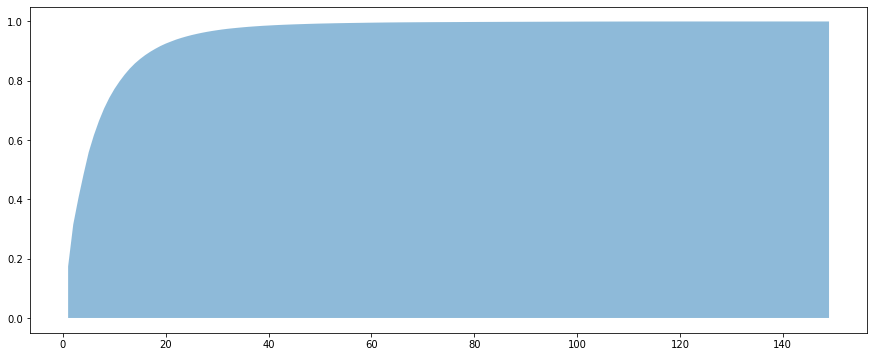

In [116]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15, 6))
plt.fill_between(df_sum['n_tokens'], df_sum['cum_rat'], alpha=0.5)
plt.legend
plt.show()


In [40]:
rv = df[df['app_nm']=='discord']['review']
n_words = 20
rvs, rvs_t, rvs_n, rvs_t_n = meaningful_sentences(rv, n_words)

print('DISCORD\n')
print("Review numbers: ",len(rv))
print("Sentence numbers: ", len(rvs))
print(f"Sentence more than {n_words} words numbers: ", len(rvs_n))
for i in range(10):
  print(rvs_n[i], " --- ", rvs_t_n[i])

DISCORD

Review numbers:  165190
Sentence numbers:  236085
Sentence more than 20 words numbers:  29977
can you please fix this,I was going on discord and I was going to login and it said "new login location detected please check your email" ok so my email and password was right, I did the recapta,and it still didn't workplease fix  ---  ['can', 'you', 'please', 'fix', 'this,I', 'was', 'going', 'on', 'discord', 'and', 'I', 'was', 'going', 'to', 'login', 'and', 'it', 'said', '"new', 'login', 'location', 'detected', 'please', 'check', 'your', 'email"', 'ok', 'so', 'my', 'email', 'and', 'password', 'was', 'right,', 'I', 'did', 'the', 'recapta,and', 'it', 'still', "didn't", 'workplease', 'fix']
Love the app my problem is there is a bug going on with discord that frequently disabled audio for music and other audio apps for galaxy note 8 when you receive messages  ---  ['Love', 'the', 'app', 'my', 'problem', 'is', 'there', 'is', 'a', 'bug', 'going', 'on', 'with', 'discord', 'that', 'frequentl

In [9]:
rv = df[df['app_nm']=='fbm']['review']
n_words = 20
rvs, rvs_t, rvs_n, rvs_t_n = meaningful_sentences(rv, n_words)

print('FACEBOOK MESSENGER\n')
print("Review numbers: ",len(rv))
print("Sentence numbers: ", len(rvs))
print(f"Sentence more than {n_words} words numbers: ", len(rvs_n))
for i in range(10):
  print(rvs_n[i], " --- ", rvs_t_n[i])

FACEBOOK MESSENGER

Review numbers:  673606
Sentence numbers:  816739
Sentence more than 20 words numbers:  46868
Well, the only thing that I can say is "I did enjoy this Messenger" that's all thank you Google Play Store  ---  ['Well,', 'the', 'only', 'thing', 'that', 'I', 'can', 'say', 'is', '"I', 'did', 'enjoy', 'this', 'Messenger"', "that's", 'all', 'thank', 'you', 'Google', 'Play', 'Store.']
I enjoyed it at first connecting with friends and family Now that is not happeningI keep getting messages no access messing with my phone keep asking me to delete other appsto install   ---  ['I', 'enjoyed', 'it', 'at', 'first', 'connecting', 'with', 'friends', 'and', 'family', '.Now', 'that', 'is', 'not', 'happening.I', 'keep', 'getting', 'messages', 'no', 'access', 'messing', 'with', 'my', 'phone', 'keep', 'asking', 'me', 'to', 'delete', 'other', 'apps.to', 'install', '.']
Hi i have one review with the latest update, before it was perfect when i wanted to enter in my gallery of photos i could

In [12]:
df[df['app_nm']=='fbm']['review'][100:200].tolist()

["I can't sign out",
 '2good',
 'Nice',
 'Excellent',
 'Its great',
 'Love this',
 'Rahul shareef gilgiti',
 'I like it',
 'So good',
 'Varry nice app',
 'Nice app',
 'Very good and efficient',
 'OK this time experience',
 "I can't get into my account",
 'Dont feel safe on th iy s App.',
 "You guys still selling our info to affect our democratic elections in favor of fascist like Donald ' Dotard ' Trump ?",
 'I love messenger its really cool! But nowdays im suffering with phone call problem please fix this as soon as possible.',
 'How to people new version ap date But..low data use is simling aap',
 'Good app',
 '🔫',
 'Osm',
 'Good',
 'Nice social app',
 'Good app',
 'Good',
 "Great but sometimes it won't let send a message. Says I need to install but it already is.",
 'Good App',
 'very burst and bad app who not installed',
 'Good',
 'Its amazing i get to see my friends from so far away! I give ut a 5 star.',
 'Good',
 'Mice Nice',
 "It's aa great video audio and chatting app",
 'Afte

In [ ]:
# autocorrect slangs

In [ ]:
# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def preprocess_text(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmas = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmas.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmas.append(lemmatizer.lemmatize(word, tag))
    keywords_l = [lemma for lemma in lemmas if lemma not in stopwords.words('english')] 
    detoken = " ".join(lemmas)
    keywords_s = list(set(keywords_l))
    freqs = dict((x, keywords_l.count(x)) for x in keywords_s)

    return lemmas, keywords_l, keywords_s, detoken, freqs

In [ ]:
# text = "Many existing state-of-the-art models are first pre-trained on a large text corpus and then fine-tuned on downstream tasks."
text = "Censor this Facebook!!"
lemmas, keywords_l, keywords_s, detoken, freqs = preprocess_text(text) 
# keywords = preprocess_text(lemm)
print(lemmas)
print(detoken)
print(keywords_l)
print(keywords_s)
print(freqs)

['Censor', 'this', 'Facebook', '!', '!']
Censor this Facebook ! !
['Censor', 'Facebook', '!', '!']
['Censor', 'Facebook', '!']
{'Censor': 1, 'Facebook': 1, '!': 2}


In [ ]:
result = dict({'lemmas':[], 
               'keywords_l':[],
               'keywords_s':[],
               'detoken':[],
               'freqs':[]
               })
print(len(rvs_new))
rvs_test = rvs_new[:10]
for i, r in enumerate(rvs_new):
  if i%1000==0:
    print(i, end=" - ")
  if i%10000==0:
    print('\n')
  lemmas, keywords_l, keywords_s, detoken, freqs = preprocess_text(r) 
  result['lemmas'].append(lemmas)
  result['keywords_l'].append(keywords_l)
  result['keywords_s'].append(keywords_s)
  result['detoken'].append(detoken)
  result['freqs'].append(freqs)

# print(result.items())
# for key, value in result.items():
#     print(key, ":", value)

print("\n",len(result['lemmas']))
print(len(result['keywords_l']))
print(len(result['keywords_s']))
print(len(result['detoken']))
print(len(result['freqs']))

95769
0 - 

1000 - 2000 - 3000 - 4000 - 5000 - 6000 - 7000 - 8000 - 9000 - 10000 - 

11000 - 12000 - 13000 - 14000 - 15000 - 16000 - 17000 - 18000 - 19000 - 20000 - 

21000 - 22000 - 23000 - 24000 - 25000 - 26000 - 27000 - 28000 - 29000 - 30000 - 

31000 - 32000 - 33000 - 34000 - 35000 - 36000 - 37000 - 38000 - 39000 - 40000 - 

41000 - 42000 - 43000 - 44000 - 45000 - 46000 - 47000 - 48000 - 49000 - 50000 - 

51000 - 52000 - 53000 - 54000 - 55000 - 56000 - 57000 - 58000 - 59000 - 60000 - 

61000 - 62000 - 63000 - 64000 - 65000 - 66000 - 67000 - 68000 - 69000 - 70000 - 

71000 - 72000 - 73000 - 74000 - 75000 - 76000 - 77000 - 78000 - 79000 - 80000 - 

81000 - 82000 - 83000 - 84000 - 85000 - 86000 - 87000 - 88000 - 89000 - 90000 - 

91000 - 92000 - 93000 - 94000 - 95000 - 
 95769
95769
95769
95769
95769


In [ ]:
keyw_l_l[:10]

[['After',
  'accept',
  'my',
  'join',
  'request',
  'by',
  'the',
  'host',
  'the',
  'screen',
  'show',
  'blank',
  'or',
  'connecting'],
 ['After',
  'accept',
  'join',
  'request',
  'host',
  'screen',
  'show',
  'blank',
  'connecting'],
 ['request',
  'After',
  'join',
  'screen',
  'accept',
  'show',
  'blank',
  'host',
  'connecting'],
 'After accept my join request by the host the screen show blank or connecting',
 {'After': 1,
  'accept': 1,
  'blank': 1,
  'connecting': 1,
  'host': 1,
  'join': 1,
  'request': 1,
  'screen': 1,
  'show': 1},
 ['I',
  "'ve",
  'miss',
  'many',
  'of',
  'my',
  'class',
  'due',
  'to',
  'this',
  'problem'],
 ['I', "'ve", 'miss', 'many', 'class', 'due', 'problem'],
 ['I', 'due', "'ve", 'problem', 'miss', 'many', 'class'],
 "I 've miss many of my class due to this problem",
 {"'ve": 1, 'I': 1, 'class': 1, 'due': 1, 'many': 1, 'miss': 1, 'problem': 1}]

In [ ]:
df2 = pd.DataFrame.from_dict({'review':rvs, 
                              'detoken':detoken_1,
                              'items': items_l})

In [ ]:
df_m = pd.merge(df, df2, left_index=True, right_index=True)

In [ ]:
df_en.to_pickle('data/processed/rv_en_1.pkl')
df_ko.to_pickle('data/processed/rv_ko_1.pkl')

In [ ]:
import csv
import json

csvfile = open('file.csv', 'r')
jsonfile = open('file.json', 'w')

fieldnames = ("FirstName","LastName","IDNumber","Message")
reader = csv.DictReader( csvfile, fieldnames)
out = json.dumps( [ row for row in reader ] )
jsonfile.write(out)